## Import Library & API

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ardl import ARDL, ardl_select_order, UECM
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import fredapi as fa
from datetime import date
from twelvedata import TDClient
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import re
import os
os.chdir('/Users/fulinq/Documents/KMITL/FinancialEngineering/Y4/Y4T1/PROJECT/ARDL-ECM/Code/Gold')

In [2]:
fred = fa.Fred(api_key='c948956426006ca126a2dd3bd1f07cee')
td = TDClient(apikey='aa61c51218c248698467af34d09b9d46')

## Data Retrieve ##

In [3]:
def select_column(df, col_name, col_rename = 'close'):
    df_clean = df[[col_name]].copy()

    # Rename column
    df_clean.rename(columns={col_name: col_rename}, inplace=True)
    df_clean.index = pd.to_datetime(df_clean.index).tz_localize(None)
    df_clean = df_clean.sort_index()
    df_clean = df_clean[~df_clean.index.duplicated(keep='first')]
    nan_count_before = df_clean.isna().sum().sum()
    df_clean = df_clean.ffill()
    nan_count_after = df_clean.isna().sum().sum()
    
    print(f"NaN filled: {nan_count_before} -> {nan_count_after}")
    print(f"Total records for {col_name}: {len(df_clean)}")
    print("-" * 30)

    return df_clean

def fetch_twelvedata_10k(td_client, symbol="XAU/USD", col_name="Gold", timezone="Asia/Bangkok", save_csv=True):
    
    # 1. Fetch First Batch (Latest 5000 records)
    ts1 = td_client.time_series(
        symbol=symbol,
        interval="1day",
        outputsize=5000,
        timezone=timezone
    )
    df1 = ts1.as_pandas()
    
    if df1 is None or df1.empty:
        raise ValueError(f"No data returned for {symbol}. Check your API key or Symbol.")
    
    oldest_date = df1.index.min()

    time.sleep(10) 

    ts2 = td_client.time_series(
        symbol=symbol,
        interval="1day",
        outputsize=5000,
        timezone=timezone,
        end_date=oldest_date
    )
    df2 = ts2.as_pandas()

    raw_df = pd.concat([df1, df2])
    
    # Save raw data if requested
    if save_csv:
        filename = f"all_{col_name.lower()}_data.csv"
        raw_df.to_csv(filename)
        print(f"Raw data saved to {filename}")

    return raw_df

def fetch_fred(fred_client, series_id, col_name, percent = False, save_csv=False):
    df = fred_client.get_series(series_id)
    df.index = pd.to_datetime(df.index) 
    print(f'NaN value before processing: {df.isna().sum()}')
    df = df.ffill()
    print(f'NaN value after processing: {df.isna().sum()}')
    df.rename(col_name, inplace=True)
    print(f'Total records for {col_name}: {len(df)}')
    print(f'start date: {df.index.min()}, end date: {df.index.max()}')
    
    if percent:
        df = df.mul(0.01)
        print(f'Total records for {col_name} in percent: {len(df)}')
    
    if save_csv:
        filename = f"all_{col_name.lower()}_data_fred.csv"
        df.to_csv(filename)
        print(f"FRED data saved to {filename}")
    
    return pd.DataFrame(df)

In [4]:
gold = fetch_twelvedata_10k(td, symbol="XAU/USD", col_name="Gold", timezone="Asia/Bangkok", save_csv=True)
gold = select_column(gold, col_name="close", col_rename="Gold")
gold

Raw data saved to all_gold_data.csv
NaN filled: 0 -> 0
Total records for close: 10000
------------------------------


,Gold
datetime,
1988-01-22,477.47000
1988-01-25,469.44000
1988-01-26,470.07001
1988-01-27,465.78000
1988-01-28,466.56000
...,...
2026-02-12,4945.17940
2026-02-13,5029.89519
2026-02-14,5043.16482


In [5]:
dollar_index = fetch_fred(fred, series_id='DTWEXBGS', col_name='Dollar Index')
dollar_index

NaN value before processing: 207
NaN value after processing: 0
Total records for Dollar Index: 5245
start date: 2006-01-02 00:00:00, end date: 2026-02-06 00:00:00


,Dollar Index
2006-01-02,101.4155
2006-01-03,100.7558
2006-01-04,100.2288
2006-01-05,100.2992
2006-01-06,100.0241
...,...
2026-02-02,118.3609
2026-02-03,117.9764
2026-02-04,118.2602
2026-02-05,118.5034


In [6]:
ppi = fetch_fred(fred, series_id='PPIACO', col_name='PPI')
ppi

NaN value before processing: 0
NaN value after processing: 0
Total records for PPI: 1356
start date: 1913-01-01 00:00:00, end date: 2025-12-01 00:00:00


,PPI
1913-01-01,12.100
1913-02-01,12.000
1913-03-01,12.000
1913-04-01,12.000
1913-05-01,11.900
...,...
2025-08-01,262.110
2025-09-01,262.094
2025-10-01,260.724
2025-11-01,261.358


In [7]:
fed_fund = fetch_fred(fred, series_id='FEDFUNDS', col_name='Federal Fund Rate', percent=True)
fed_fund

NaN value before processing: 0
NaN value after processing: 0
Total records for Federal Fund Rate: 859
start date: 1954-07-01 00:00:00, end date: 2026-01-01 00:00:00
Total records for Federal Fund Rate in percent: 859


,Federal Fund Rate
1954-07-01,0.0080
1954-08-01,0.0122
1954-09-01,0.0107
1954-10-01,0.0085
1954-11-01,0.0083
...,...
2025-09-01,0.0422
2025-10-01,0.0409
2025-11-01,0.0388
2025-12-01,0.0372


In [8]:
vix = fetch_fred(fred, series_id='VIXCLS', percent=True,col_name='VIX')
vix['VIX'] = vix['VIX'].mul(1 / np.sqrt(252))
vix

NaN value before processing: 301
NaN value after processing: 0
Total records for VIX: 9423
start date: 1990-01-02 00:00:00, end date: 2026-02-12 00:00:00
Total records for VIX in percent: 9423


,VIX
1990-01-02,0.010860
1990-01-03,0.011459
1990-01-04,0.012107
1990-01-05,0.012668
1990-01-08,0.012763
...,...
2026-02-06,0.011188
2026-02-09,0.010936
2026-02-10,0.011207
2026-02-11,0.011118


In [9]:
unemploy = fetch_fred(fred, series_id='ICSA', col_name='ISCA') #Initial Claims
unemploy

NaN value before processing: 0
NaN value after processing: 0
Total records for ISCA: 3084
start date: 1967-01-07 00:00:00, end date: 2026-02-07 00:00:00


,ISCA
1967-01-07,208000.0
1967-01-14,207000.0
1967-01-21,217000.0
1967-01-28,204000.0
1967-02-04,216000.0
...,...
2026-01-10,199000.0
2026-01-17,210000.0
2026-01-24,209000.0
2026-01-31,232000.0


In [10]:
ip = fetch_fred(fred, series_id='INDPRO', col_name='IP')
ip

NaN value before processing: 0
NaN value after processing: 0
Total records for IP: 1284
start date: 1919-01-01 00:00:00, end date: 2025-12-01 00:00:00


,IP
1919-01-01,4.8739
1919-02-01,4.6585
1919-03-01,4.5238
1919-04-01,4.6046
1919-05-01,4.6315
...,...
2025-08-01,101.5867
2025-09-01,101.7779
2025-10-01,101.5163
2025-11-01,101.9528


In [11]:
gdp = fetch_fred(fred, series_id='GDP', col_name='GDP')
gdp

NaN value before processing: 4
NaN value after processing: 4
Total records for GDP: 319
start date: 1946-01-01 00:00:00, end date: 2025-07-01 00:00:00


,GDP
1946-01-01,NaN
1946-04-01,NaN
1946-07-01,NaN
1946-10-01,NaN
1947-01-01,243.164
...,...
2024-07-01,29511.664
2024-10-01,29825.182
2025-01-01,30042.113
2025-04-01,30485.729


In [12]:
def chow_lin_disaggregate(y_low: pd.Series, X_high: pd.DataFrame,
                          agg_method: str = 'sum', rho: float = None) -> tuple:
    """
    Chow-Lin temporal disaggregation: แปลงข้อมูลความถี่ต่ำ (Quarterly) เป็นความถี่สูง (Monthly)
    โดยใช้ GLS estimation เพื่อจัดการกับ Autocorrelation
    """
    # 1) Align data (ตัดข้อมูลให้ช่วงเวลาตรงกัน)
    y_low = y_low.dropna().copy()
    X_high = X_high.dropna().copy()
    n_high_per_low = 3  # Quarterly -> Monthly = 3 เดือนต่อไตรมาส

    # หาช่วงเวลาที่ซ้อนทับกัน (Overlapping period)
    quarters = y_low.index
    months = X_high.index
    min_date = max(quarters.min(), months.min().to_period('Q').to_timestamp())
    max_date = min(quarters.max(), months.max().to_period('Q').to_timestamp())

    y_low = y_low[(y_low.index >= min_date) & (y_low.index <= max_date)]
    
    # ปรับช่วงเวลาของ Monthly ให้ครอบคลุม Quarterly พอดี
    month_start = y_low.index.min()
    month_end = (y_low.index.max() + pd.offsets.QuarterEnd()).to_period('M').to_timestamp()
    X_high = X_high[(X_high.index >= month_start) & (X_high.index <= month_end)]

    n_low = len(y_low)
    n_high = n_low * n_high_per_low
    X_high = X_high.iloc[:n_high] # ตัดส่วนเกินออก

    # 2) Build aggregation matrix C (Matrix สำหรับแปลงรายเดือนกลับเป็นไตรมาส)
    C = np.zeros((n_low, n_high))
    for i in range(n_low):
        start_col = i * n_high_per_low
        end_col = start_col + n_high_per_low
        if agg_method == 'sum': # สำหรับ Flow variable เช่น GDP
            C[i, start_col:end_col] = 1.0
        elif agg_method == 'mean': # สำหรับ Stock variable
            C[i, start_col:end_col] = 1.0 / n_high_per_low
        else:
            C[i, end_col - 1] = 1.0

    # 3) Prepare X matrix
    X = X_high.values
    if X.ndim == 1: X = X.reshape(-1, 1)
    X = np.column_stack([np.ones(n_high), X]) # เพิ่ม Intercept

    # 4) OLS เบื้องต้นเพื่อหาค่า Rho (Autocorrelation coefficient)
    X_low = C @ X
    y = y_low.values.flatten()
    beta_ols = np.linalg.lstsq(X_low, y, rcond=None)[0]
    u_low = y - X_low @ beta_ols

    if rho is None: # ถ้าไม่ได้กำหนดมา ให้คำนวณจาก Residuals
        if len(u_low) > 1:
            rho = np.corrcoef(u_low[:-1], u_low[1:])[0, 1]
            rho = np.clip(rho, -0.99, 0.99)
        else:
            rho = 0.0

    # 5) GLS Estimation (พระเอกของงาน)
    # สร้าง Covariance Matrix V ตามโครงสร้าง AR(1)
    V = np.zeros((n_high, n_high))
    for i in range(n_high):
        for j in range(n_high):
            V[i, j] = rho ** abs(i - j)

    V_low = C @ V @ C.T
    try:
        V_low_inv = np.linalg.inv(V_low)
    except:
        V_low_inv = np.linalg.pinv(V_low)

    # คำนวณ Beta ด้วย GLS
    XVX = X_low.T @ V_low_inv @ X_low
    XVy = X_low.T @ V_low_inv @ y
    try:
        beta_gls = np.linalg.solve(XVX, XVy)
    except:
        beta_gls = np.linalg.lstsq(XVX, XVy, rcond=None)[0]

    # 6) คำนวณค่าพยากรณ์และกระจาย Error (Distribute residuals)
    p_high = X @ beta_gls
    u_low_gls = y - X_low @ beta_gls
    VCt = V @ C.T
    
    try:
        dist_matrix = VCt @ np.linalg.inv(V_low)
    except:
        dist_matrix = VCt @ np.linalg.pinv(V_low)

    y_high = p_high + dist_matrix @ u_low_gls # ผลลัพธ์สุดท้าย

    result = pd.Series(y_high, index=X_high.index, name='GDP_Monthly_ChowLin')
    return result, beta_gls, rho

In [13]:
y_target = gdp['GDP']
X_indicator = ip[['IP']]

gdp_monthly_gls, beta, rho = chow_lin_disaggregate(y_low=y_target, X_high=X_indicator, agg_method='sum', rho=None)
print("Estimated Rho (Autocorrelation):", rho)
gdp = gdp_monthly_gls.copy()
gdp_monthly_gls

Estimated Rho (Autocorrelation): 0.99


1947-01-01       77.773508
1947-02-01       80.692880
1947-03-01       84.697612
1947-04-01       78.954153
1947-05-01       82.894249
                  ...     
2025-05-01    10144.558754
2025-06-01    10243.572273
2025-07-01    10350.178201
2025-08-01    10371.135506
2025-09-01    10376.713293
Name: GDP_Monthly_ChowLin, Length: 945, dtype: float64

In [14]:
fed_balance = fetch_fred(fred, series_id='WALCL', col_name='Fed Balance Sheet') #Federal Reserve Total Assets
fed_balance

NaN value before processing: 0
NaN value after processing: 0
Total records for Fed Balance Sheet: 1209
start date: 2002-12-18 00:00:00, end date: 2026-02-11 00:00:00


,Fed Balance Sheet
2002-12-18,719542.0
2002-12-25,732059.0
2003-01-01,730994.0
2003-01-08,723762.0
2003-01-15,720074.0
...,...
2026-01-14,6581700.0
2026-01-21,6584580.0
2026-01-28,6587568.0
2026-02-04,6605909.0


In [15]:
# 1. organize data
realtime_data = {
    'gold': gold,
    'dollar_index': dollar_index,
    'vix': vix,
    'fed_rate': fed_fund,
    'fed_balance': fed_balance,
    'labor_claims': unemploy
}

lagged_data = {
    'ip': ip,
    'gdp': gdp,
    'ppi': ppi
}

# 2. resample & rename
monthly_dfs = []

# process real-time
for name, data in realtime_data.items():
    # FIX: force rename for both Series and DataFrame to match the key (lowercase)
    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0].to_frame(name)
    else:
        data = data.to_frame(name)
    
    if name in ['labor_claims', 'vix']:
        monthly_dfs.append(data.resample('ME').mean())
    else:
        monthly_dfs.append(data.resample('ME').last())

# process lagged
for name, data in lagged_data.items():
    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0].to_frame(name)
    else:
        data = data.to_frame(name)
    monthly_dfs.append(data.resample('ME').last())

# 3. merge
df_final = pd.concat(monthly_dfs, axis=1)

# 4. handle lag (shift)
vars_to_shift = ['ip', 'ppi']
for col in vars_to_shift:
    df_final[col] = df_final[col].shift(1)
df_final['gdp'] = df_final['gdp'].shift(4)

# 5. target variable
df_final['target_gold'] = df_final['gold'].shift(-1)

# 6. feature selection
features = [
    'gold', 'dollar_index', 'vix', 'fed_rate', 
    'fed_balance', 'labor_claims', 
    'ip', 'gdp','ppi'
]

df_model = df_final[features + ['target_gold']].dropna()

# check
print(f"data range: {df_model.index.min().date()} to {df_model.index.max().date()}")
print(df_model.columns)
df_model

data range: 2006-01-31 to 2026-01-31
Index(['gold', 'dollar_index', 'vix', 'fed_rate', 'fed_balance',
       'labor_claims', 'ip', 'gdp', 'ppi', 'target_gold'],
      dtype='object')


,gold,dollar_index,vix,fed_rate,fed_balance,labor_claims,ip,gdp,ppi,target_gold
2006-01-31,568.95001,99.4311,0.007560,0.0429,828901.0,295750.0,98.0452,4330.637985,163.000,561.75000
2006-02-28,561.75000,99.7695,0.007842,0.0449,840555.0,290750.0,98.1999,4387.339722,164.300,583.65002
2006-03-31,583.65002,100.5600,0.007366,0.0459,833675.0,301750.0,98.2413,4449.366642,161.800,654.50000
2006-04-30,654.50000,98.1412,0.007480,0.0479,844572.0,303600.0,98.4628,4487.497636,162.200,643.70001
2006-05-31,643.70001,97.7705,0.009100,0.0494,851580.0,332750.0,98.7618,4515.041039,164.300,613.09998
...,...,...,...,...,...,...,...,...,...,...
2025-09-30,3869.18000,120.1368,0.009946,0.0422,6608395.0,234750.0,101.5867,10144.558754,262.110,3995.65000
2025-10-31,3995.65000,121.3859,0.011393,0.0409,6587034.0,226750.0,101.7779,10243.572273,262.094,4216.34338
2025-11-30,4216.34338,121.0527,0.012454,0.0388,6552419.0,217600.0,101.5163,10350.178201,260.724,4311.26879
2025-12-31,4311.26879,119.7456,0.009738,0.0372,6640618.0,219000.0,101.9528,10371.135506,261.358,4865.45982


In [16]:
df_model.to_csv('gold_price_model_data.csv')

In [17]:
df_ret = pd.DataFrame()
cols_to_transform = ['gold', 'gdp', 'ip', 'ppi','dollar_index', 'labor_claims', 'fed_balance'] # ไม่เอา IP, PPI ตามแผน Core Model
cols_not_to_transform = ['fed_rate', 'vix'] # ตัวแปรที่ไม่ทำ log return
for col in cols_to_transform:
    if col in df_model.columns:
        df_ret[f'{col}_ret'] = np.log(df_model[col]).diff()
for col in cols_not_to_transform:
    if col in df_model.columns:
        df_ret[f'{col}_change'] = df_model[col].diff()
    
df_ret.dropna(inplace=True)
df_ret

,gold_ret,gdp_ret,ip_ret,ppi_ret,dollar_index_ret,labor_claims_ret,fed_balance_ret,fed_rate_change,vix_change
2006-02-28,-0.012736,0.013008,0.001577,0.007944,0.003398,-0.017051,0.013962,0.0020,0.000282
2006-03-31,0.038245,0.014039,0.000422,-0.015333,0.007892,0.037135,-0.008219,0.0010,-0.000475
2006-04-30,0.114570,0.008533,0.002252,0.002469,-0.024347,0.006112,0.012986,0.0020,0.000113
2006-05-31,-0.016639,0.006119,0.003032,0.012864,-0.003784,0.091680,0.008263,0.0015,0.001620
2006-06-30,-0.048705,0.003576,0.000254,0.009088,0.004875,-0.085442,-0.008424,0.0005,0.001558
...,...,...,...,...,...,...,...,...,...
2025-09-30,0.110673,0.004640,-0.003020,-0.000946,-0.000594,0.020442,0.000759,-0.0011,0.000025
2025-10-31,0.032164,0.009713,0.001880,-0.000061,0.010344,-0.034673,-0.003238,-0.0013,0.001447
2025-11-30,0.053762,0.010353,-0.002574,-0.005241,-0.002749,-0.041190,-0.005269,-0.0021,0.001060
2025-12-31,0.022264,0.002023,0.004291,0.002429,-0.010856,0.006413,0.013371,-0.0016,-0.002716


## Data Preparation ##

In [18]:
df_model = pd.read_csv('gold_price_model_data.csv', index_col=0, parse_dates=True)
df_model

,gold,dollar_index,vix,fed_rate,fed_balance,labor_claims,ip,gdp,ppi,target_gold
2006-01-31,568.95001,99.4311,0.007560,0.0429,828901.0,295750.0,98.0452,4330.637985,163.000,561.75000
2006-02-28,561.75000,99.7695,0.007842,0.0449,840555.0,290750.0,98.1999,4387.339722,164.300,583.65002
2006-03-31,583.65002,100.5600,0.007366,0.0459,833675.0,301750.0,98.2413,4449.366642,161.800,654.50000
2006-04-30,654.50000,98.1412,0.007480,0.0479,844572.0,303600.0,98.4628,4487.497636,162.200,643.70001
2006-05-31,643.70001,97.7705,0.009100,0.0494,851580.0,332750.0,98.7618,4515.041039,164.300,613.09998
...,...,...,...,...,...,...,...,...,...,...
2025-09-30,3869.18000,120.1368,0.009946,0.0422,6608395.0,234750.0,101.5867,10144.558754,262.110,3995.65000
2025-10-31,3995.65000,121.3859,0.011393,0.0409,6587034.0,226750.0,101.7779,10243.572273,262.094,4216.34338
2025-11-30,4216.34338,121.0527,0.012454,0.0388,6552419.0,217600.0,101.5163,10350.178201,260.724,4311.26879
2025-12-31,4311.26879,119.7456,0.009738,0.0372,6640618.0,219000.0,101.9528,10371.135506,261.358,4865.45982


In [19]:
vars_to_log = ['gold', 'dollar_index', 'fed_balance', 'labor_claims', 'ip', 'ppi', 'target_gold']
for col in vars_to_log:
    df_model[f'ln_{col}'] = np.log(df_model[col])

model_vars = ['fed_rate', 'vix'] + [f'ln_{c}' for c in vars_to_log]
df_ardl = df_model[model_vars].dropna()

df_ardl

,fed_rate,vix,ln_gold,ln_dollar_index,ln_fed_balance,ln_labor_claims,ln_ip,ln_ppi,ln_target_gold
2006-01-31,0.0429,0.007560,6.343793,4.599465,13.627856,12.597270,4.585429,5.093750,6.331057
2006-02-28,0.0449,0.007842,6.331057,4.602863,13.641818,12.580219,4.587005,5.101694,6.369302
2006-03-31,0.0459,0.007366,6.369302,4.610755,13.633599,12.617354,4.587427,5.086361,6.483872
2006-04-30,0.0479,0.007480,6.483872,4.586407,13.646585,12.623466,4.589679,5.088830,6.467233
2006-05-31,0.0494,0.009100,6.467233,4.582623,13.654849,12.715147,4.592711,5.101694,6.418528
...,...,...,...,...,...,...,...,...,...
2025-09-30,0.0422,0.009946,8.260798,4.788631,15.703851,12.366276,4.620913,5.568764,8.292962
2025-10-31,0.0409,0.011393,8.292962,4.798975,15.700614,12.331603,4.622793,5.568703,8.346724
2025-11-30,0.0388,0.012454,8.346724,4.796226,15.695345,12.290414,4.620219,5.563462,8.368988
2025-12-31,0.0372,0.009738,8.368988,4.785369,15.708716,12.296827,4.624510,5.565891,8.489917


In [20]:
def run_adf_test(series, name):
    # Test at Level
    result = adfuller(series.dropna())
    p_value = result[1]
    
    if p_value <= 0.05:
        return f"I(0) - Stationary (p={p_value:.4f})"
    else:
        # ถ้า Level ไม่นิ่ง ให้ลอง Test แบบ Diff (First Difference)
        diff_result = adfuller(series.diff().dropna())
        diff_p_value = diff_result[1]
        
        if diff_p_value <= 0.05:
            return f"I(1) - Stationary at Diff (p={diff_p_value:.4f})"
        else:
            return f"I(2) or Higher (Non-Stationary) (p={diff_p_value:.4f})"

summary_data = []
for col in df_ardl.columns:
    status = run_adf_test(df_ardl[col], col)
    summary_data.append({'Variable': col, 'Status': status})

df_status = pd.DataFrame(summary_data)
df_status

,Variable,Status
0,fed_rate,I(1) - Stationary at Diff (p=0.0050)
1,vix,I(0) - Stationary (p=0.0008)
2,ln_gold,I(1) - Stationary at Diff (p=0.0000)
3,ln_dollar_index,I(1) - Stationary at Diff (p=0.0000)
4,ln_fed_balance,I(1) - Stationary at Diff (p=0.0000)
5,ln_labor_claims,I(0) - Stationary (p=0.0182)
6,ln_ip,I(1) - Stationary at Diff (p=0.0000)
7,ln_ppi,I(1) - Stationary at Diff (p=0.0000)
8,ln_target_gold,I(1) - Stationary at Diff (p=0.0000)


In [21]:
X_cols = ['fed_rate', 
          'ln_gold', 
          'ln_dollar_index', 
          'vix', 
          'ln_labor_claims', 
          'ln_ip', 
          'ln_ppi', 
        #   'ln_fed_balance'
          ]

X = df_ardl[X_cols].dropna()
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

,Variable,VIF
0,const,29151.133420
1,fed_rate,1.444787
2,ln_gold,5.066762
3,ln_dollar_index,1.821538
4,vix,1.741195
5,ln_labor_claims,2.576050
6,ln_ip,1.995322
7,ln_ppi,6.128517


In [22]:
y_col = 'ln_gold'
X_cols = ['fed_rate', 
          'ln_dollar_index', 
          'vix', 
          'ln_labor_claims', 
          'ln_ip', 
          'ln_ppi',
        #   'ln_fed_balance'
          ]

data_ardl = df_ardl[[y_col] + X_cols].dropna()

model_ardl = ARDL(data_ardl[y_col], lags=1, exog=data_ardl[X_cols], order=1)
res_ardl = model_ardl.fit()
res_ardl.summary()

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARDL Model Results                                 
=====================================================================================
Dep. Variable:                       ln_gold   No. Observations:                  241
Model:             ARDL(1, 1, 1, 1, 1, 1, 1)   Log Likelihood                 425.402
Method:                      Conditional MLE   S.D. of innovations              0.041
Date:                       Mon, 16 Feb 2026   AIC                           -820.804
Time:                               10:21:04   BIC                           -768.594
Sample:                           02-28-2006   HQIC                          -799.767
                                - 01-31-2026                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1960      0.517      0.379      0.705      -0.822       1.214
ln_gold.L1             0.9864      0.018     54.255      0.000       0.951       1.022
fed_rate.L0           -2.8934      2.212     -1.308      0.192      -7.253       1.466
fed_rate.L1            3.0973      2.150      1.441      0.151      -1.139       7.334
ln_dollar_index.L0    -1.3758      0.181     -7.620      0.000      -1.732      -1.020
ln_dollar_index.L1     1.4098      0.180      7.812      0.000       1.054       1.765
vix.L0                 1.8259      1.229      1.485      0.139      -0.597       4.249
vix.L1                -1.3402      1.161     -1.154      0.250      -3.628       0.948
ln_labor_claims.L0    -0.0103      0.019     -0.536      0.592      -0.048       0.027
ln_labor_claims.L1     0.0095      0.019      0.485      0.628      -0.029       0.048
ln_ip.L0               0.3250      0.253      1.283      0.201      -0.174       0.824
ln_ip.L1              -0.4381      0.241     -1.818      0.070      -0.913       0.037
ln_ppi.L0             -0.5455      0.248     -2.196      0.029      -1.035      -0.056
ln_ppi.L1              0.5971      0.253      2.361      0.019       0.099       1.095
======================================================================================
"""

In [23]:
model_uecm = UECM(data_ardl[y_col], lags=1, exog=data_ardl[X_cols], order=1)
res_uecm = model_uecm.fit()
res_uecm.summary()

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  UECM Model Results                                 
=====================================================================================
Dep. Variable:                     D.ln_gold   No. Observations:                  241
Model:             UECM(1, 1, 1, 1, 1, 1, 1)   Log Likelihood                 425.402
Method:                      Conditional MLE   S.D. of innovations              7.240
Date:                       Mon, 16 Feb 2026   AIC                           -820.804
Time:                               10:21:04   BIC                           -768.594
Sample:                           02-28-2006   HQIC                          -799.767
                                - 01-31-2026                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1960      0.517      0.379      0.705      -0.822       1.214
ln_gold.L1              -0.0136      0.018     -0.748      0.455      -0.049       0.022
fed_rate.L1              0.2039      0.182      1.119      0.264      -0.155       0.563
ln_dollar_index.L1       0.0340      0.033      1.018      0.310      -0.032       0.100
vix.L1                   0.4857      0.872      0.557      0.578      -1.234       2.205
ln_labor_claims.L1      -0.0008      0.011     -0.074      0.941      -0.022       0.021
ln_ip.L1                -0.1130      0.102     -1.107      0.269      -0.314       0.088
ln_ppi.L1                0.0516      0.057      0.903      0.367      -0.061       0.164
D.fed_rate.L0           -2.8934      2.212     -1.308      0.192      -7.253       1.466
D.ln_dollar_index.L0    -1.3758      0.181     -7.620      0.000      -1.732      -1.020
D.vix.L0                 1.8259      1.229      1.485      0.139      -0.597       4.249
D.ln_labor_claims.L0    -0.0103      0.019     -0.536      0.592      -0.048       0.027
D.ln_ip.L0               0.3250      0.253      1.283      0.201      -0.174       0.824
D.ln_ppi.L0             -0.5455      0.248     -2.196      0.029      -1.035      -0.056
========================================================================================
"""

In [24]:
ect_coeff = res_uecm.params[f'{y_col}.L1']
ect_pvalue = res_uecm.pvalues[f'{y_col}.L1']
print(f"\nค่า ECT Coefficient: {ect_coeff:.5f}")
print(f"P-value: {ect_pvalue:.5f}")

if ect_coeff < 0 and ect_pvalue < 0.05:
    print("✅ pass: significant and negative ECT (having long-term equilibrium adjustment)")
else:
    print("❌ fail: ECT is positive or not significant (try reducing lag or check variables again)")


ค่า ECT Coefficient: -0.01359
P-value: 0.45539
❌ fail: ECT is positive or not significant (try reducing lag or check variables again)


## AIC Individual Selection ##

In [25]:
y_col = 'ln_gold'
X_cols = ['fed_rate', 
          'ln_dollar_index', 
          'vix', 
          'ln_labor_claims', 
          'ln_ip', 
          'ln_ppi',
        #   'ln_fed_balance'
          ]

data_ardl = df_ardl[[y_col] + X_cols].dropna()

custom_max_order = {
    'fed_rate': 6,
    'ln_dollar_index': 5,
    'vix': 3,
    'ln_labor_claims': 6,
    'ln_ip': 4,
    'ln_ppi': 4
}

sel_res = ardl_select_order(
    data_ardl[y_col], 
    maxlag=6, 
    exog=data_ardl[X_cols], 
    maxorder=custom_max_order,
    ic='aic'
)

print(f"Best AR Lags: {sel_res.ar_lags}")
print(f"Best DL Orders: {sel_res.dl_lags}")

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Best AR Lags: [1, 2]
Best DL Orders: {'fed_rate': [0, 1, 2, 3, 4, 5, 6], 'ln_dollar_index': [0, 1, 2], 'vix': [0, 1], 'ln_labor_claims': [0, 1, 2], 'ln_ip': [0, 1], 'ln_ppi': [0, 1]}


In [26]:
ar_lag = max(sel_res.ar_lags) if isinstance(sel_res.ar_lags, list) else sel_res.ar_lags
dl_lags = {k: (max(v) if isinstance(v, list) else v) for k, v in sel_res.dl_lags.items()}

print(f"\n--- 2. ARDL Levels Analysis & Bounds Test ---")
model_ardl = ARDL(
    data_ardl[y_col], 
    lags=ar_lag, 
    exog=data_ardl[X_cols], 
    order=dl_lags
)
res_ardl = model_ardl.fit()
res_ardl.summary()


--- 2. ARDL Levels Analysis & Bounds Test ---


/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARDL Model Results                                 
=====================================================================================
Dep. Variable:                       ln_gold   No. Observations:                  241
Model:             ARDL(2, 6, 2, 1, 2, 1, 1)   Log Likelihood                 444.952
Method:                      Conditional MLE   S.D. of innovations              0.038
Date:                       Mon, 16 Feb 2026   AIC                           -843.904
Time:                               10:22:02   BIC                           -763.946
Sample:                           07-31-2006   HQIC                          -811.683
                                - 01-31-2026                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6262      0.516      1.213      0.226      -0.391       1.643
ln_gold.L1             0.7996      0.065     12.370      0.000       0.672       0.927
ln_gold.L2             0.1945      0.067      2.918      0.004       0.063       0.326
fed_rate.L0           -1.0731      2.722     -0.394      0.694      -6.437       4.291
fed_rate.L1            3.6964      4.915      0.752      0.453      -5.991      13.383
fed_rate.L2           -8.7487      4.860     -1.800      0.073     -18.328       0.831
fed_rate.L3            3.4162      4.529      0.754      0.451      -5.510      12.342
fed_rate.L4           -2.2749      4.415     -0.515      0.607     -10.976       6.426
fed_rate.L5           13.0619      4.231      3.087      0.002       4.723      21.401
fed_rate.L6           -7.9005      2.231     -3.542      0.000     -12.297      -3.504
ln_dollar_index.L0    -1.4177      0.173     -8.201      0.000      -1.758      -1.077
ln_dollar_index.L1     1.0953      0.247      4.441      0.000       0.609       1.581
ln_dollar_index.L2     0.3589      0.188      1.910      0.057      -0.011       0.729
vix.L0                 4.7279      1.311      3.608      0.000       2.145       7.311
vix.L1                -3.5602      1.239     -2.873      0.004      -6.002      -1.118
ln_labor_claims.L0    -0.0405      0.021     -1.946      0.053      -0.081       0.001
ln_labor_claims.L1     0.1047      0.033      3.126      0.002       0.039       0.171
ln_labor_claims.L2    -0.0801      0.022     -3.638      0.000      -0.123      -0.037
ln_ip.L0               0.7481      0.274      2.728      0.007       0.208       1.289
ln_ip.L1              -0.9122      0.274     -3.326      0.001      -1.453      -0.372
ln_ppi.L0             -0.5816      0.246     -2.363      0.019      -1.067      -0.096
ln_ppi.L1              0.6186      0.254      2.432      0.016       0.117       1.120
======================================================================================
"""

In [27]:
model_uecm = UECM(
    data_ardl[y_col], 
    lags=ar_lag, 
    exog=data_ardl[X_cols], 
    order=dl_lags
)
res_uecm = model_uecm.fit()

ect_coef = res_uecm.params[f'{y_col}.L1']
ect_pval = res_uecm.pvalues[f'{y_col}.L1']

print(f"\n*** FINAL CHECK ***")
print(f"ECT Coefficient: {ect_coef:.5f}")
print(f"P-value:         {ect_pval:.5f}")

if ect_coef < 0 and ect_pval < 0.05:
    print("✅ Model is Valid: Correct adjustment speed")
else:
    print("❌ Model Issue: ECT is positive or insignificant")
    
res_uecm.summary()


*** FINAL CHECK ***
ECT Coefficient: -0.00589
P-value:         0.75379
❌ Model Issue: ECT is positive or insignificant


/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  UECM Model Results                                 
=====================================================================================
Dep. Variable:                     D.ln_gold   No. Observations:                  241
Model:             UECM(2, 6, 2, 1, 2, 1, 1)   Log Likelihood                 444.952
Method:                      Conditional MLE   S.D. of innovations              7.196
Date:                       Mon, 16 Feb 2026   AIC                           -843.904
Time:                               10:22:02   BIC                           -763.946
Sample:                           07-31-2006   HQIC                          -811.683
                                - 01-31-2026                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6262      0.516      1.213      0.226      -0.391       1.643
ln_gold.L1              -0.0059      0.019     -0.314      0.754      -0.043       0.031
fed_rate.L1              0.1772      0.188      0.943      0.347      -0.193       0.548
ln_dollar_index.L1       0.0365      0.032      1.142      0.255      -0.027       0.100
vix.L1                   1.1677      0.895      1.305      0.193      -0.596       2.932
ln_labor_claims.L1      -0.0159      0.011     -1.464      0.145      -0.037       0.006
ln_ip.L1                -0.1641      0.101     -1.627      0.105      -0.363       0.035
ln_ppi.L1                0.0370      0.059      0.628      0.531      -0.079       0.153
D.ln_gold.L1            -0.1945      0.067     -2.918      0.004      -0.326      -0.063
D.fed_rate.L0           -1.0731      2.722     -0.394      0.694      -6.437       4.291
D.fed_rate.L1            2.4461      2.978      0.821      0.412      -3.423       8.315
D.fed_rate.L2           -6.3026      2.749     -2.292      0.023     -11.722      -0.884
D.fed_rate.L3           -2.8864      2.578     -1.119      0.264      -7.968       2.196
D.fed_rate.L4           -5.1614      2.598     -1.986      0.048     -10.283      -0.040
D.fed_rate.L5            7.9005      2.231      3.542      0.000       3.504      12.297
D.ln_dollar_index.L0    -1.4177      0.173     -8.201      0.000      -1.758      -1.077
D.ln_dollar_index.L1    -0.3589      0.188     -1.910      0.057      -0.729       0.011
D.vix.L0                 4.7279      1.311      3.608      0.000       2.145       7.311
D.ln_labor_claims.L0    -0.0405      0.021     -1.946      0.053      -0.081       0.001
D.ln_labor_claims.L1     0.0801      0.022      3.638      0.000       0.037       0.123
D.ln_ip.L0               0.7481      0.274      2.728      0.007       0.208       1.289
D.ln_ppi.L0             -0.5816      0.246     -2.363      0.019      -1.067      -0.096
========================================================================================
"""

## Model 1 ARDL Forecast

In [28]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ardl import ARDL, ardl_select_order

# Custom Dict เดิมของคุณ
custom_max_order = {
    'fed_rate': 6,
    'ln_dollar_index': 5,
    'vix': 3,
    'ln_labor_claims': 6,
    'ln_ip': 4,
    'ln_ppi': 4
}

def run_dynamic_walk_forward(data, y_col, X_cols, train_ratio=0.7, max_lag_dict=custom_max_order, max_ar=2):
    # Setup Frequency (ป้องกัน Error เรื่อง Index)
    if data.index.freq is None:
        try:
            data.index.freq = pd.infer_freq(data.index)
        except:
            pass

    # 1. แบ่งช่วง Train เริ่มต้น
    train_size = int(len(data) * train_ratio)
    
    predictions = []
    actuals = []
    dates = []
    selected_lags_history = [] 

    print(f"--- Starting Dynamic Walk-Forward ---")
    print(f"Total Data: {len(data)} | Initial Train: {train_size} | Test Steps: {len(data) - train_size}")

    # 2. เริ่ม Loop (Walk-Forward)
    for i in range(train_size, len(data)):
        
        # (A) ข้อมูล Train ณ ปัจจุบัน (Expanding Window)
        train_df = data.iloc[:i]
        
        # วันที่กำลังจะทำนาย
        current_step_date = data.index[i]
        
        # (B) หา Best Lag ใหม่ทุกรอบ
        sel_res = ardl_select_order(
            train_df[y_col], 
            maxlag=max_ar,             
            exog=train_df[X_cols], 
            maxorder=max_lag_dict,     
            ic='aic', 
            trend='c'
        )
        
        # (C) บังคับ Min Lag = 1
        ar_lags = sel_res.ar_lags or 0
        
        dl_orders = {}
        for var, lags in sel_res.dl_lags.items():
            if isinstance(lags, int):
                lags_list = list(range(lags + 1))
            else:
                lags_list = list(lags)
            
            clean_lags = [L for L in lags_list if L > 0]
            if not clean_lags: clean_lags = [1]
            dl_orders[var] = clean_lags
            
        selected_lags_history.append(str(dl_orders))

        # (D) Fit Model
        model = ARDL(
            endog=train_df[y_col], 
            lags=ar_lags, 
            exog=train_df[X_cols], 
            order=dl_orders, 
            trend='c',
            causal=True 
        )
        res = model.fit()
        
        # (E) Forecast 1 Step ข้างหน้า (ใช้ .forecast แทน .get_prediction)
        # ------------------------------------------------------------------
        current_exog = data[X_cols].iloc[[i]]
        
        # forecast จะรู้เองว่าเป็น Step ถัดไป และรับ exog ของ Step นั้นๆ ได้เลย
        forecast_val = res.forecast(steps=1, exog=current_exog)
        
        # ดึงค่าออกมา (forecast อาจคืนค่าเป็น Series)
        if isinstance(forecast_val, (pd.Series, pd.DataFrame)):
            pred_val = forecast_val.iloc[0]
        else:
            pred_val = forecast_val
        # ------------------------------------------------------------------

        predictions.append(pred_val)
        actuals.append(data[y_col].iloc[i])
        dates.append(data.index[i])

        # Print Progress
        step_count = i - train_size + 1
        if step_count % 10 == 0 or i == len(data) - 1:
            date_str = current_step_date.strftime('%Y-%m-%d')
            print(f"Step {step_count}: Processing Date {date_str}")

    # 3. สรุปผล
    results_df = pd.DataFrame({
        'Date': dates,
        'Actual': actuals,
        'Predicted': predictions,
        'Lags_Used': selected_lags_history
    }).set_index('Date')

    # คำนวณ Error & Un-log
    results_df['Error'] = results_df['Actual'] - results_df['Predicted']
    results_df['Actual_Price'] = np.exp(results_df['Actual'])
    results_df['Predicted_Price'] = np.exp(results_df['Predicted'])
    results_df['Error_Price'] = results_df['Actual_Price'] - results_df['Predicted_Price']

    return results_df

# เรียกใช้งาน
result = run_dynamic_walk_forward(data_ardl, y_col, X_cols, train_ratio=0.7, max_lag_dict=custom_max_order)
result

--- Starting Dynamic Walk-Forward ---
Total Data: 241 | Initial Train: 168 | Test Steps: 73


/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ln_ppi.
  return _format_order(self.data.orig_exog, order, self._causal)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ln_ppi.
  return _format_order(self.data.orig_exog, order, self._causal)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ln_ppi.
  return _format_order(self.data.orig_exog, order, self._causal)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing

Step 10: Processing Date 2020-10-31


/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ln_ppi.
  return _format_order(self.data.orig_exog, order, self._causal)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ln_ppi.
  return _format_order(self.data.orig_exog, order, self._causal)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ln_ppi.
  return _format_order(self.data.orig_exog, order, self._causal)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing

Step 20: Processing Date 2021-08-31
Step 30: Processing Date 2022-06-30
Step 40: Processing Date 2023-04-30
Step 50: Processing Date 2024-02-29
Step 60: Processing Date 2024-12-31
Step 70: Processing Date 2025-10-31
Step 73: Processing Date 2026-01-31


,Actual,Predicted,Lags_Used,Error,Actual_Price,Predicted_Price,Error_Price
Date,,,,,,,
2020-01-31,7.371615,7.319262,"{'fed_rate': [1, 2, 3, 4, 5, 6], 'ln_dollar_in...",0.052353,1590.19995,1509.090477,81.109473
2020-02-29,7.368415,7.388206,"{'fed_rate': [1, 2, 3, 4, 5, 6], 'ln_dollar_in...",-0.019791,1585.12000,1616.803673,-31.683673
2020-03-31,7.359665,7.356805,"{'fed_rate': [1, 2, 3, 4, 5, 6], 'ln_dollar_in...",0.002860,1571.31006,1566.822332,4.487728
2020-04-30,7.429551,7.154177,"{'fed_rate': [1, 2, 3, 4, 5, 6], 'ln_dollar_in...",0.275374,1685.05005,1279.439030,405.611020
2020-05-31,7.454894,7.891849,"{'fed_rate': [1, 2, 3, 4, 5, 6], 'ln_dollar_in...",-0.436956,1728.30005,2675.386713,-947.086663
...,...,...,...,...,...,...,...
2025-09-30,8.260798,8.154589,"{'fed_rate': [1, 2, 3, 4, 5, 6], 'ln_dollar_in...",0.106209,3869.18000,3479.309938,389.870062
2025-10-31,8.292962,8.255573,"{'fed_rate': [1, 2, 3, 4, 5, 6], 'ln_dollar_in...",0.037389,3995.65000,3849.015252,146.634748
2025-11-30,8.346724,8.304657,"{'fed_rate': [1, 2, 3, 4, 5, 6], 'ln_dollar_in...",0.042066,4216.34338,4042.656748,173.686632


In [29]:
rmse = np.sqrt(mean_squared_error(np.exp(result['Actual']), np.exp(result['Predicted'])))
mae = mean_absolute_error(np.exp(result['Actual']), np.exp(result['Predicted']))
r2 = r2_score(np.exp(result['Actual']), np.exp(result['Predicted']))

print("-" * 50)
print(f"✅ Forecast Complete!")
print(f"Range: {result.index.min().date()} -> {result.index.max().date()}")
print(f"Total Forecasted Months: {len(result)}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE:  {mae:.5f}")
# print(f"R² (Out-of-Sample): {r2:.5f}") # อย่าตกใจถ้า R2 ติดลบ (เป็นปกติของ Time Series ระยะยาว)
print("-" * 50)

--------------------------------------------------
✅ Forecast Complete!
Range: 2020-01-31 -> 2026-01-31
Total Forecasted Months: 73
RMSE: 209.17819
MAE:  120.17530
--------------------------------------------------


In [30]:
best_order_no_lag0 = {}
for var, lags in sel_res.dl_lags.items():
    best_order_no_lag0[var] = [1]

X_cols = list(best_order_no_lag0.keys())
data_for_wf = df_ardl[[y_col] + X_cols].dropna()

def run_walking_forward(data, y_col, X_cols, order_dict, train_ratio=0.7):
    # Set frequency to avoid statsmodels ValueWarning (Assuming Monthly 'M')
    if data.index.freq is None:
        data.index.freq = pd.infer_freq(data.index)

    train_size = int(len(data) * train_ratio)
    predictions = []
    actuals = []
    dates = []

    print(f"Starting Walking Forward... Total Steps: {len(data) - train_size}")

    for i in range(train_size, len(data)):
        # (A) Prepare Training Data (All data up to index i-1)
        train_df = data.iloc[:i]
        
        # (B) Initialize and Fit ARDL Model
        # Using causal=True ensures the model is strictly for forecasting
        model = ARDL(train_df[y_col], lags=1, exog=train_df[X_cols], 
                     order=order_dict, causal=True)
        res = model.fit()
        
        # (C) One-Step Ahead Forecast
        # We pass the exog data of current step (i) so the model can pull 
        # previous lags (t-1, t-2, etc.) to predict current y[i]
        current_exog = data[X_cols].iloc[[i]]
        forecast_val = res.forecast(steps=1, exog=current_exog)
        
        predictions.append(forecast_val.values[0])
        actuals.append(data[y_col].iloc[i])
        dates.append(data.index[i])

    # Wrap results in DataFrame
    results_df = pd.DataFrame({
        'Date': dates,
        'Actual': actuals,
        'Predicted': predictions
    }).set_index('Date')
    print(res.summary())
    return results_df

results = run_walking_forward(data_for_wf, y_col, X_cols, best_order_no_lag0)

results['Error'] = results['Actual'] - results['Predicted']
results['Actual_Price'] = np.exp(results['Actual'])
results['Predicted_Price'] = np.exp(results['Predicted'])
results['Error_Price'] = results['Actual_Price'] - results['Predicted_Price']
print("\n--- Walking Forward Results ---")
results

Starting Walking Forward... Total Steps: 73
                                  ARDL Model Results                                 
Dep. Variable:                       ln_gold   No. Observations:                  240
Model:             ARDL(1, 1, 1, 1, 1, 1, 1)   Log Likelihood                 394.541
Method:                      Conditional MLE   S.D. of innovations              0.046
Date:                       Mon, 16 Feb 2026   AIC                           -771.081
Time:                               11:22:02   BIC                           -739.793
Sample:                           02-28-2006   HQIC                          -758.473
                                - 12-31-2025                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6905      0.520      1.328      0.185      -0.334       1.715
ln_gold

,Actual,Predicted,Error,Actual_Price,Predicted_Price,Error_Price
Date,,,,,,
2020-01-31,7.371615,7.314256,0.057359,1590.19995,1501.554963,88.644987
2020-02-29,7.368415,7.370451,-0.002036,1585.12000,1588.350340,-3.230340
2020-03-31,7.359665,7.378217,-0.018552,1571.31006,1600.732981,-29.422921
2020-04-30,7.429551,7.177193,0.252358,1685.05005,1309.228106,375.821944
2020-05-31,7.454894,7.473227,-0.018334,1728.30005,1760.278780,-31.978730
...,...,...,...,...,...,...
2025-09-30,8.260798,8.154218,0.106580,3869.18000,3478.019135,391.160865
2025-10-31,8.292962,8.269091,0.023871,3995.65000,3901.401058,94.248942
2025-11-30,8.346724,8.303499,0.043224,4216.34338,4037.977962,178.365418


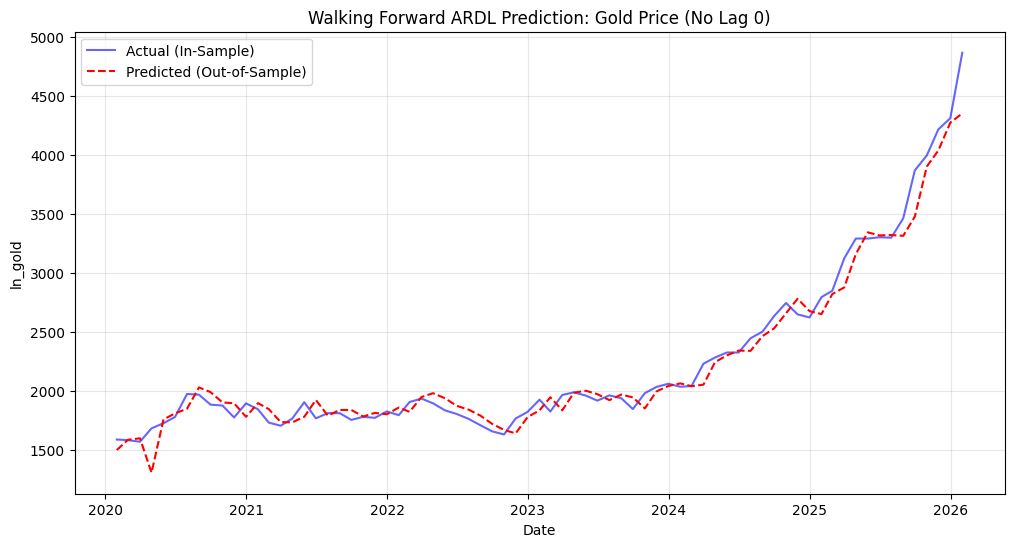

In [31]:
# Visualizing Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(np.exp(results['Actual']), label='Actual (In-Sample)', color='blue', alpha=0.6)
plt.plot(np.exp(results['Predicted']), label='Predicted (Out-of-Sample)', color='red', linestyle='--')
plt.title('Walking Forward ARDL Prediction: Gold Price (No Lag 0)')
plt.xlabel('Date')
plt.ylabel('ln_gold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [32]:
rmse = np.sqrt(mean_squared_error(np.exp(results['Actual']), np.exp(results['Predicted'])))
mae = mean_absolute_error(np.exp(results['Actual']), np.exp(results['Predicted']))
r2 = r2_score(np.exp(results['Actual']), np.exp(results['Predicted']))

print("-" * 50)
print(f"✅ Forecast Complete!")
print(f"Range: {results.index.min().date()} -> {results.index.max().date()}")
print(f"Total Forecasted Months: {len(results)}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE:  {mae:.5f}")
# print(f"R² (Out-of-Sample): {r2:.5f}") # อย่าตกใจถ้า R2 ติดลบ (เป็นปกติของ Time Series ระยะยาว)
print("-" * 50)

--------------------------------------------------
✅ Forecast Complete!
Range: 2020-01-31 -> 2026-01-31
Total Forecasted Months: 73
RMSE: 122.47122
MAE:  86.07362
--------------------------------------------------


## AIC ARDL WF Forecast

In [33]:
# 1. Extract and Transform Lags from AIC result (Excluding Lag 0)
best_order_no_lag0 = {}
for var, lags in sel_res.dl_lags.items():
    # Find the maximum lag selected by AIC
    max_l = max(lags) if isinstance(lags, (list, np.ndarray)) else lags
    
    if max_l >= 1:
        # Create a list of lags starting from 1 to max_l (e.g., [1, 2, 3])
        # This is required by statsmodels to avoid the "strictly positive" error
        best_order_no_lag0[var] = list(range(1, max_l + 1))
    else:
        # If AIC only chose Lag 0, force it to Lag 1 for forecasting capability
        best_order_no_lag0[var] = [1] 
        print(f"⚠️ Warning: {var} only had Lag 0. Forced to [1] for forecasting.")

X_cols = list(best_order_no_lag0.keys())


# --- Execution ---
# Clean data for ARDL execution
data_for_wf = df_ardl[[y_col] + X_cols].dropna()

# Run the simulation
results = run_walking_forward(data_for_wf, y_col, X_cols, best_order_no_lag0)

# --- Performance Evaluation ---
results['Error'] = results['Actual'] - results['Predicted']
results['Actual_Price'] = np.exp(results['Actual'])
results['Predicted_Price'] = np.exp(results['Predicted'])
results['Error_Price'] = results['Actual_Price'] - results['Predicted_Price']
print("\n--- Walking Forward Results ---")
results

Starting Walking Forward... Total Steps: 73
                                  ARDL Model Results                                 
Dep. Variable:                       ln_gold   No. Observations:                  240
Model:             ARDL(1, 6, 2, 1, 2, 1, 1)   Log Likelihood                 405.442
Method:                      Conditional MLE   S.D. of innovations              0.044
Date:                       Mon, 16 Feb 2026   AIC                           -778.884
Time:                               11:22:03   BIC                           -723.261
Sample:                           07-31-2006   HQIC                          -756.469
                                - 12-31-2025                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.0493      0.572      1.836      0.068      -0.077       2.176
ln_gold

,Actual,Predicted,Error,Actual_Price,Predicted_Price,Error_Price
Date,,,,,,
2020-01-31,7.371615,7.307084,0.064531,1590.19995,1490.823781,99.376169
2020-02-29,7.368415,7.378990,-0.010575,1585.12000,1601.971486,-16.851486
2020-03-31,7.359665,7.370763,-0.011098,1571.31006,1588.846063,-17.536003
2020-04-30,7.429551,7.048056,0.381495,1685.05005,1150.619813,534.430237
2020-05-31,7.454894,7.521496,-0.066602,1728.30005,1847.328237,-119.028187
...,...,...,...,...,...,...
2025-09-30,8.260798,8.154049,0.106749,3869.18000,3477.429884,391.750116
2025-10-31,8.292962,8.268386,0.024575,3995.65000,3898.653427,96.996573
2025-11-30,8.346724,8.303894,0.042830,4216.34338,4039.570502,176.772878


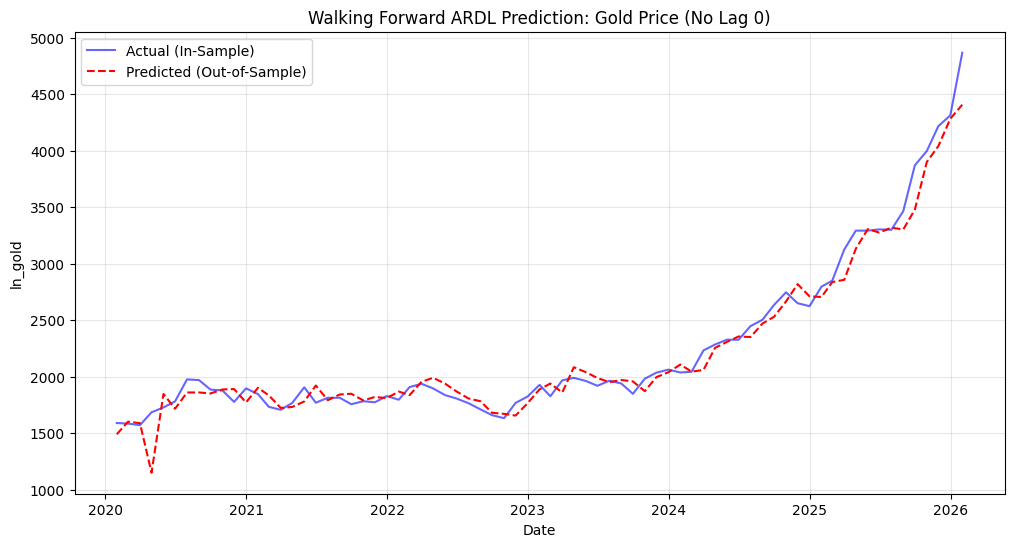

In [34]:
# Visualizing Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(np.exp(results['Actual']), label='Actual (In-Sample)', color='blue', alpha=0.6)
plt.plot(np.exp(results['Predicted']), label='Predicted (Out-of-Sample)', color='red', linestyle='--')
plt.title('Walking Forward ARDL Prediction: Gold Price (No Lag 0)')
plt.xlabel('Date')
plt.ylabel('ln_gold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [35]:
rmse = np.sqrt(mean_squared_error(np.exp(results['Actual']), np.exp(results['Predicted'])))
mae = mean_absolute_error(np.exp(results['Actual']), np.exp(results['Predicted']))
r2 = r2_score(np.exp(results['Actual']), np.exp(results['Predicted']))

print("-" * 50)
print(f"✅ Forecast Complete!")
print(f"Range: {results.index.min().date()} -> {results.index.max().date()}")
print(f"Total Forecasted Months: {len(results)}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE:  {mae:.5f}")
# print(f"R² (Out-of-Sample): {r2:.5f}") # อย่าตกใจถ้า R2 ติดลบ (เป็นปกติของ Time Series ระยะยาว)
print("-" * 50)

--------------------------------------------------
✅ Forecast Complete!
Range: 2020-01-31 -> 2026-01-31
Total Forecasted Months: 73
RMSE: 128.65438
MAE:  88.44387
--------------------------------------------------


## Technical Variables Integration ##

In [36]:
macro_feature = results[['Predicted']].copy()
macro_feature.columns = ['Macro_Signal']

macro_daily = macro_feature.resample('D').asfreq()
macro_daily = macro_daily.fillna(method='ffill')
macro_daily

/var/folders/rc/w7r40l35143bxwkzfxdygctc0000gn/T/ipykernel_74640/2938975789.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_daily = macro_daily.fillna(method='ffill')


,Macro_Signal
Date,
2020-01-31,7.307084
2020-02-01,7.307084
2020-02-02,7.307084
2020-02-03,7.307084
2020-02-04,7.307084
...,...
2026-01-27,8.362089
2026-01-28,8.362089
2026-01-29,8.362089


In [37]:
df_daily = pd.read_csv('all_gold_data.csv', index_col=0, parse_dates=True)
df_daily.sort_index(inplace=True)
df_daily = df_daily[~df_daily.index.duplicated(keep='first')]
df_daily['close_ret'] = np.log(df_daily['close']).diff()
df_daily['ln_close'] = np.log(df_daily['close'])

df_daily.ta.rsi(length=14, append=True) # Momentum
df_daily.ta.macd(fast=12, slow=26, signal=9, append=True) # Trend & Momentum
df_daily.ta.adx(length=14, append=True) # Trend Strength
df_daily.ta.cci(length=20, append=True) # Cyclical Trend
df_daily.ta.bbands(length=20, std=2, append=True) # Volatility
df_daily.ta.atr(length=14, append=True) # Volatility
df_daily.ta.ema(length=50, append=True)
df_daily.ta.ema(length=200, append=True)
df_daily['dist_ema50'] = (df_daily['close'] - df_daily['EMA_50']) / df_daily['EMA_50']
df_daily['dist_ema200'] = (df_daily['close'] - df_daily['EMA_200']) / df_daily['EMA_200']
df_daily['daily_range'] = (df_daily['high'] - df_daily['low']) / df_daily['open']

rolling_mean = df_daily['close'].rolling(window=20).mean()
rolling_std = df_daily['close'].rolling(window=20).std()
df_daily['z_score'] = (df_daily['close'] - rolling_mean) / rolling_std

cols_to_drop = [
    'EMA_50', 'EMA_200',      # เราใช้ dist_ema แทนแล้ว
    'BBU_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0' # เราใช้ bb_width กับ bb_percentage แทนแล้ว
]

cols_to_drop = [c for c in cols_to_drop if c in df_daily.columns]
df_daily.drop(columns=cols_to_drop, inplace=True)
df_daily.dropna(inplace=True)
df_daily

,open,high,low,close,close_ret,ln_close,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,DMP_14,DMN_14,CCI_20_0.015,BBB_20_2.0,BBP_20_2.0,ATRr_14,dist_ema50,dist_ema200,daily_range,z_score
datetime,,,,,,,,,,,,,,,,,,,,,
1988-10-28,415.69000,415.69000,412.16000,412.16000,0.012279,6.021412,56.111923,-0.152975,0.906451,-1.059426,...,31.036898,27.549494,115.732182,4.310173,0.821626,3.688810,-0.001785,-0.057537,0.008492,1.253928
1988-10-31,413.70001,413.70001,412.16000,412.16000,0.000000,6.021412,56.111923,0.174270,0.986957,-0.812687,...,30.071192,26.692298,98.890595,3.931053,0.805750,3.535325,-0.001715,-0.056997,0.003723,1.192033
1988-11-01,412.04999,412.04999,411.04999,411.04999,-0.002697,6.018715,53.968754,0.340126,0.922250,-0.582124,...,29.362038,28.421077,66.690551,3.369434,0.727139,3.362088,-0.004232,-0.058979,0.002427,0.885549
1988-11-02,422.22000,422.22000,421.32999,421.32999,0.024702,6.043416,66.666637,1.286250,1.494699,-0.208450,...,41.917845,22.636087,261.140079,3.991934,1.256073,3.919797,0.019845,-0.035105,0.002108,2.947716
1988-11-03,424.70001,424.70001,421.06000,421.06000,-0.000641,6.042775,66.150517,1.991320,1.759815,0.231504,...,43.665542,21.126937,223.616283,4.534536,1.102048,3.899812,0.018425,-0.035380,0.008571,2.347216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-12,5080.93854,5101.36263,4891.22479,4945.17940,-0.027027,8.506169,52.396448,76.256091,-11.988625,88.244716,...,24.771730,28.723196,-5.817815,11.441327,0.417412,162.886817,0.039862,0.189820,0.041358,-0.321988
2026-02-13,4944.94520,5045.31285,4892.56375,5029.89519,0.016986,8.523154,56.042009,74.684357,-10.848287,85.532644,...,23.105035,26.790638,0.561324,11.452702,0.561485,162.162695,0.055289,0.207677,0.030890,0.239714
2026-02-14,5029.60512,5044.24291,5023.95409,5043.16482,0.002635,8.525789,56.602628,73.660383,-9.497809,83.158192,...,22.884789,26.535259,30.144933,11.473859,0.579182,152.028846,0.055669,0.208328,0.004034,0.308707


In [38]:
df_final = macro_daily.join(df_daily, how='inner')
df_final['target_return'] = np.log(df_final['close']).diff().shift(-1)
df_final.dropna(inplace=True)

threshold = 0.00
conditions = [
    (df_final['target_return'] >= threshold),
    (df_final['target_return'] < -threshold)
]

choices = [1, 0]
df_final['signal'] = np.select(conditions, choices, default=0)

df_final.to_csv('gold_technical.csv')
df_final

,Macro_Signal,open,high,low,close,close_ret,ln_close,RSI_14,MACD_12_26_9,MACDh_12_26_9,...,CCI_20_0.015,BBB_20_2.0,BBP_20_2.0,ATRr_14,dist_ema50,dist_ema200,daily_range,z_score,target_return,signal
2020-01-31,7.307084,1574.27002,1590.19995,1570.83997,1590.19995,0.010100,7.371615,69.147939,17.168392,-0.020438,...,141.705401,2.864311,1.092919,15.843121,0.038728,0.090678,0.012298,2.311625,-0.008684,0
2020-02-03,7.307084,1589.84998,1591.85999,1571.26001,1576.44995,-0.008684,7.362931,60.992502,16.481626,-0.565763,...,105.059582,2.949481,0.766197,16.182897,0.028546,0.080374,0.012957,1.037826,-0.015277,0
2020-02-04,7.307084,1576.30005,1579.54004,1548.98999,1552.55005,-0.015277,7.347654,49.962196,13.849192,-2.558557,...,-20.579420,2.960124,0.272055,17.209122,0.012439,0.063318,0.019381,-0.888695,0.002669,1
2020-02-05,7.307084,1552.56995,1562.31006,1547.19995,1556.69995,0.002669,7.350323,51.598982,11.959964,-3.558228,...,-49.470854,2.953276,0.360464,17.059193,0.014542,0.065458,0.009732,-0.544013,0.006499,1
2020-02-06,7.307084,1556.88000,1568.29004,1552.23999,1566.84998,0.006499,7.356823,55.438427,11.153193,-3.491999,...,-4.829537,2.888760,0.566063,16.987111,0.020311,0.071633,0.010309,0.257561,0.002193,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-26,8.362089,4982.40644,5108.49956,4979.13611,5029.16284,0.009331,8.523009,86.334446,150.999548,35.386448,...,149.111263,15.942001,0.955341,69.050904,0.110050,0.256737,0.025964,1.775246,0.013829,1
2026-01-27,8.362089,5029.23113,5102.59816,4999.05307,5099.19537,0.013829,8.536838,88.039607,161.196205,36.466484,...,135.931642,16.867650,0.975066,71.514775,0.119995,0.270770,0.020589,1.852149,0.043739,1
2026-01-28,8.362089,5099.19820,5329.23026,5098.86184,5327.17903,0.043739,8.580577,91.679427,185.534775,48.644043,...,171.520198,19.229419,1.113936,82.861464,0.162318,0.323272,0.045177,2.393561,-0.003130,0
2026-01-29,8.362089,5326.98804,5597.22988,5122.53750,5310.53137,-0.003130,8.577447,89.536686,201.161081,51.416279,...,170.118994,20.762581,1.006485,110.849386,0.151520,0.314961,0.089111,1.974641,-0.072191,0


## CNN

In [39]:
# Macro preparation
macro_for_cnn = pd.DataFrame(index=df_ret.index)
macro_for_cnn['macro_fed_change'] = df_ret['fed_change']

X_ols = sm.add_constant(df_ret[['fed_change']].shift(1))
macro_for_cnn['macro_resid'] = results['Error']

# Merge with daily technical data
df_cnn = df_final.copy()

features_to_merge = ['macro_fed_change', 'macro_resid']
for col in features_to_merge:
    daily_macro = macro_for_cnn[col].resample('D').ffill()
    df_cnn[col] = daily_macro
df_cnn.dropna(inplace=True)

# df_cnn
df_cnn.columns

KeyError: 'fed_change'

In [ ]:
df_cnn

,Macro_Signal,open,high,low,close,close_ret,ln_close,RSI_14,MACD_12_26_9,MACDh_12_26_9,...,BBP_20_2.0,ATRr_14,dist_ema50,dist_ema200,daily_range,z_score,target_return,signal,macro_fed_change,macro_resid
2021-03-31,7.448021,1685.59497,1715.27502,1677.92505,1707.00745,0.013097,7.442497,40.974529,-16.334942,0.342835,...,0.305922,26.835012,-0.032888,-0.051302,0.022158,-0.756657,0.013485,1,-0.0001,-0.005524
2021-04-01,7.448021,1708.09009,1730.79822,1705.41956,1730.18201,0.013485,7.455982,48.013815,-14.335840,1.873550,...,0.609687,26.730987,-0.018998,-0.038055,0.014858,0.427638,-0.000776,0,-0.0001,-0.005524
2021-04-02,7.448021,1730.47498,1732.54504,1728.67249,1728.83997,-0.000776,7.455206,47.659348,-12.713277,2.796890,...,0.572885,25.098241,-0.018999,-0.038430,0.002238,0.284159,-0.000231,0,-0.0001,-0.005524
2021-04-05,7.448021,1728.74500,1733.75000,1721.21997,1728.43994,-0.000231,7.454975,47.546670,-11.329069,3.344878,...,0.538676,24.200512,-0.018486,-0.038282,0.007248,0.150786,0.008715,1,-0.0001,-0.005524
2021-04-06,7.448021,1728.49500,1745.67505,1726.82263,1743.56995,0.008715,7.463690,52.154204,-8.908517,4.612344,...,0.790971,23.818505,-0.009510,-0.029575,0.010907,1.134416,-0.003614,0,-0.0001,-0.005524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-26,8.296974,4479.62443,4550.78973,4476.55334,4523.58231,0.009749,8.417060,83.036726,81.614524,15.478790,...,0.982387,50.861782,0.069260,0.195293,0.016572,1.880692,0.002011,1,-0.0021,0.049749
2025-12-27,8.296974,4523.48301,4534.74851,4522.15204,4532.69019,0.002011,8.419071,83.528717,85.487616,15.481506,...,0.946295,48.128545,0.068420,0.195348,0.002785,1.739978,-0.000023,0,-0.0021,0.049749
2025-12-28,8.296974,4532.61899,4532.88130,4531.44651,4532.58587,-0.000023,8.419048,83.498845,87.539551,14.026752,...,0.904088,44.793277,0.065538,0.193002,0.000317,1.575424,-0.044025,0,-0.0021,0.049749
2025-12-29,8.296974,4532.61769,4547.90835,4307.57154,4337.36579,-0.044025,8.375022,48.525433,72.576478,-0.749056,...,0.399203,58.760672,0.018860,0.140013,0.053024,-0.392979,0.002153,1,-0.0021,0.049749


In [ ]:
cnn_features = [
    'ln_close', 'RSI_14', 'MACD_12_26_9', 'MACDs_12_26_9', 'ADX_14', 
    'CCI_20_0.015', 'ATRr_14', 'daily_range', 'z_score', 'dist_ema50',
    'Macro_Signal', 'macro_fed_change', 'macro_resid'
]

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_raw = df_cnn[cnn_features].values
y_raw = df_cnn[['target_return']].values # ทำนาย Return

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

def create_sequences(data_X, data_y, time_steps):
    Xs, ys = [], []
    for i in range(len(data_X) - time_steps):
        Xs.append(data_X[i:(i + time_steps)])
        ys.append(data_y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 9
X_cnn, y_cnn = create_sequences(X_scaled, y_scaled, TIME_STEPS)

# Train/Test (no Shuffle : Time Series)
train_size = int(len(X_cnn) * 0.95)
X_train, X_test = X_cnn[:train_size], X_cnn[train_size:]
y_train, y_test = y_cnn[:train_size], y_cnn[train_size:]

print(f"Input Shape: {X_train.shape} (Samples, Time Steps, Features)")

Input Shape: (1241, 9, 13) (Samples, Time Steps, Features)


In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    
    # --- Block 1: Short-term Patterns ---
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    # --- Block 2: Long-term Trends ---
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    # --- Interpretation ---
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.1), # Prevent overfitting
    
    # --- Output ---
    Dense(32, activation='relu'),
    Dense(1, activation='linear') # Linear activation for regression
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 9, 32)          │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 9, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Stop training if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.2563 - mae: 0.8488 - val_loss: 0.3373 - val_mae: 0.5711 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1770 - mae: 0.3326 - val_loss: 0.3268 - val_mae: 0.5619 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0850 - mae: 0.2326 - val_loss: 0.2778 - val_mae: 0.5162 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0641 - mae: 0.2023 - val_loss: 0.2711 - val_mae: 0.5096 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0513 - mae: 0.1808 - val_loss: 0.2838 - val_mae: 0.5219 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0449 - mae: 0.1660 - val_loss: 0.2676 - val_mae: 0.5061 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0379 - mae: 0.1539 - val_loss: 0.2743 - val_mae: 0.5128 - learning_rate: 0.0010
Epoch 8/50
10/10 ━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


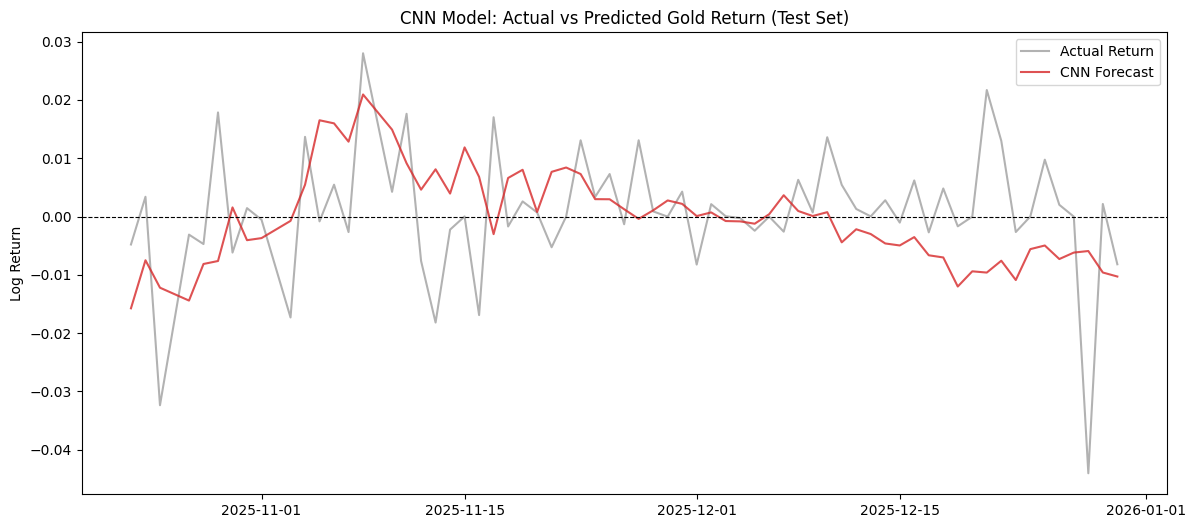

In [ ]:
# Prediction
y_pred_scaled = model.predict(X_test)

# Inverse Transform (Back to real return values)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

test_start_idx = train_size + TIME_STEPS
dates = df_cnn.index[test_start_idx : test_start_idx + len(y_actual)]

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual Return', color='gray', alpha=0.6)
plt.plot(dates, y_pred, label='CNN Forecast', color='#D62728', alpha=0.8, linewidth=1.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Zero line
plt.title('CNN Model: Actual vs Predicted Gold Return (Test Set)')
plt.ylabel('Log Return')
plt.legend()

## CNN-LSTM

In [ ]:
# --- 1. Model Architecture (Based on Livieris et al., 2020) ---
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])), # ( Time Steps, n_features)
    
    # --- Part 1: CNN Layers (Feature Extraction) ---
    # Layer 1: สกัด Feature พื้นฐาน (32-64 Filters ในเปเปอร์ แต่เราอัดไป 64 เพื่อเก็บรายละเอียด Technical)
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    
    # Layer 2: สกัด Feature ที่ซับซ้อนขึ้น (128 Filters ตามเปเปอร์)
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    
    # Pooling: ย่อข้อมูลลงครึ่งหนึ่ง (เพื่อคัดเนื้อๆ เน้นๆ)
    MaxPooling1D(pool_size=2),
    
    # --- Part 2: LSTM Layer (Temporal Learning) ---
    # รับไม้ต่อจาก CNN เพื่อดู "ลำดับเวลา" ของ Feature ที่สกัดมาได้
    # (ในเปเปอร์ใช้ 200 units ซึ่งถือว่าใหญ่และดีสำหรับข้อมูลที่มีความซับซ้อน)
    LSTM(200, return_sequences=False, activation='tanh'),
    Dropout(0.1), # ป้องกันการจำข้อสอบ (Overfitting)
    
    # --- Part 3: Fully Connected (Interpretation) ---
    Dense(32, activation='relu'), # Hidden Layer ตามเปเปอร์
    
    # Output Layer (ทำนาย Return)
    Dense(1, activation='linear')
])

# --- 2. Optimizer & Compilation ---
# ใช้ Adam (มาตรฐานโลก) และ Loss เป็น MSE
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

# # --- 3. Training ---
# # ใช้ Callbacks เดิม (EarlyStopping, ReduceLR) เพราะดีอยู่แล้ว
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 9, 64)          │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 9, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200)            │       263,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,313 (1.13 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.4721 - mae: 0.5646 - val_loss: 0.2877 - val_mae: 0.5234 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0293 - mae: 0.1349 - val_loss: 0.2716 - val_mae: 0.5063 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0140 - mae: 0.0905 - val_loss: 0.2731 - val_mae: 0.5077 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127 - mae: 0.0866 - val_loss: 0.2800 - val_mae: 0.5138 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0121 - mae: 0.0863 - val_loss: 0.3003 - val_mae: 0.5327 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0108 - mae: 0.0793 - val_loss: 0.3360 - val_mae: 0.5639 - learning_rate: 0.0010
Epoch 7/50
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0807 
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


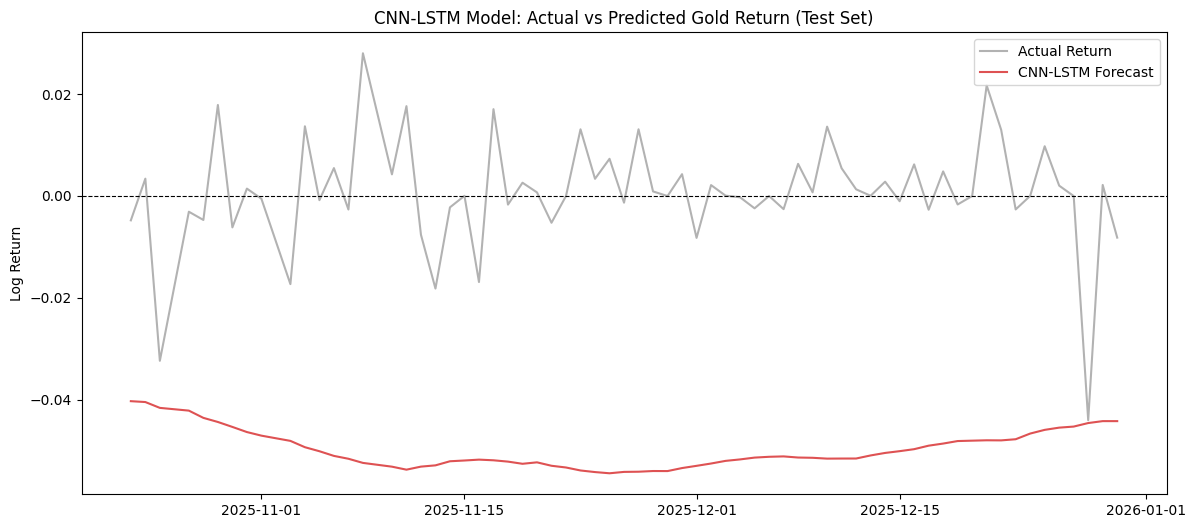

In [ ]:
# Prediction
y_pred_scaled = model.predict(X_test)

# Inverse Transform (Back to real return values)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

test_start_idx = train_size + TIME_STEPS
dates = df_cnn.index[test_start_idx : test_start_idx + len(y_actual)]

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual Return', color='gray', alpha=0.6)
plt.plot(dates, y_pred, label='CNN-LSTM Forecast', color='#D62728', alpha=0.8, linewidth=1.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Zero line
plt.title('CNN-LSTM Model: Actual vs Predicted Gold Return (Test Set)')
plt.ylabel('Log Return')
plt.legend()